# Runtime

Runtime as a function of system size.

In [ ]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

# Sampling

In [ ]:
%load_ext line_profiler

In [ ]:
from coniii.samplers import *
from coniii.utils import define_ising_helper_functions

In [ ]:
n=10
theta = np.random.normal(size=n+n*(n-1)//2)
calc_e,_,_ = define_ising_helper_functions()

sampler=FastMCIsing(n, theta)

In [13]:
%timeit sampler.generate_samples(100)

1.33 s ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit sampler.generate_samples_parallel(100)

687 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
sampler=Metropolis(n, theta, calc_e)

In [16]:
%timeit sampler.generate_samples(100)

2.73 s ± 98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit sampler.generate_samples_parallel(100)

1.32 s ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Import common libraries.
from coniii import *

# Add path to files for solving the n=5 system exactly. This is included as an example for the package, but you can create your own by using the exact module.
# To create ising_eqn_5_sym.py, run in the shell
# >>> python exact.py 5 1
from coniii.ising_eqn import ising_eqn_5_sym

# Define common functions.
calc_e, calc_observables, mchApproximation = define_ising_helper_functions()

# Generate example data set.
n = 5  # system size
np.random.seed(0)  # standardize random seed
h,J = np.random.normal(scale=.1, size=n), np.random.normal(scale=.1, size=n*(n-1)//2)  # random fields, couplings
hJ = np.concatenate((h, J))
p = ising_eqn_5_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)  # exact magnetizations and pairwise correlations

allstates = bin_states(n, True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[np.random.choice(range(2**n),
                                    size=100,
                                    replace=True,
                                    p=p)]  # random sample from p(s)
sisj = pair_corr(sample, concat=True)  # magnetizations and pairwise correlations of random sample

def error_on_correlations(estSisj):
    return np.linalg.norm( sisj - estSisj )

def error_on_multipliers(estMultipliers):
    return np.linalg.norm( hJ - estMultipliers )

In [ ]:
# Sampling parameters must be set here (in case you want to immediately sample using 
# the given set of parameters)
solver = MCH(n,
             calc_observables=calc_observables,
             sample_size=100,
             sample_method='ising_metropolis',
             mch_approximation=mchApproximation,
             n_jobs=1 )

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) and the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.),'eta':exp(-i/5.)}

# Run solver.
# solver.sampler.update_parameters(hJ)
# X=np.random.choice([-1.,1.], size=(1000,n))
# %lprun -f solver.sampler.generate_samples_parallel solver.sampler.generate_samples_parallel(1000,initial_sample=X)
%lprun -f solver.sampler.generate_samples solver.solve(constraints=sisj,maxiter=1,custom_convergence_f=learn_settings)

In [ ]:
# Sampling parameters must be set here (in case you want to immediately sample using 
# the given set of parameters)
solver = MCH(n,
             calc_observables=calc_observables,
             sample_size=100,
             sample_method='metropolis',
             mch_approximation=mchApproximation)

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) amnd the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.),'eta':exp(-i/5.)}

# Run solver.
# solver.sampler.theta=hJ
# X=np.random.choice([-1.,1.], size=(1000,n))
# %lprun -f solver.sampler.generate_samples_parallel solver.sampler.generate_samples_parallel(1000,initial_sample=X)
%lprun -f solver.sampler.generate_samples_parallel solver.solve(constraints=sisj,maxiter=1,custom_convergence_f=learn_settings)

# Inverse maxent algorithms

In [3]:
# Import common libraries.
from coniii import *
import importlib
from misc.plot import colorcycle

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_helpers_functions()


def generate_random_systems(n,n_iters,rng=np.random.RandomState(0),n_sample=20):
    ising_eqn = importlib.import_module('coniii.ising_eqn.ising_eqn_%d_sym'%n)
    allstates = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis
    
    # Generate example data set.
    h = np.random.normal(scale=.1,size=(n_iters,n))  # random fields
    J = np.random.normal(scale=.1,size=(n_iters,n*(n-1)//2))  # couplings
    sisjTrue = np.zeros((n_iters,n+n*(n-1)//2))
    p = np.zeros((n_iters,2**n))
    sample = np.zeros((n_iters,n_sample,n))
    for i in xrange(n_iters):
        hJ = np.concatenate(( h[i],J[i] ))
        p[i] = ising_eqn.p(hJ)  # probability distribution of all states p(s)
        sisjTrue[i] = ising_eqn.calc_observables(hJ)  # exact magnetizations and pairwise correlations
        sample[i,:,:] = allstates[np.random.choice(range(2**n),size=n_sample)]
    return h,J,p,sisjTrue,sample

def runtime_enumerate(n,sisjTrue):
    # Exact.
    allstates = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis
    def calc_observables_multipliers(J):
        """
        Calculate observables from probability distribution given Langrangian multipliers.
        """
        E = calc_e(allstates,J)
        return pair_corr( allstates, np.exp(-E-logsumexp(E)),concat=True )

    # Generate example data set.
    solver = Enumerate(n,
                   calc_observables_multipliers=calc_observables_multipliers,
                   calc_observables=calc_observables)
    start = datetime.now()
    estMultipliers,soln = solver.solve(constraints=sisjTrue,fsolve_kwargs={})
    end = datetime.now()

    error = np.linalg.norm( calc_observables_multipliers(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

def runtime_mpf(n,sample):
    solver = MPF(n,calc_observables=calc_observables,adj=adj)
    start = datetime.now()
    estMultipliers,soln = solver.solve(sample)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('coniii.ising_eqn.ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

def runtime_pseudo(n,sample):
    """
    Pseudolikelihood.
    """
    get_multipliers_r,calc_observables_r = define_pseudo_ising_helpers(n)
    solver = Pseudo(n,calc_observables=calc_observables,
                    calc_observables_r=calc_observables_r,
                    get_multipliers_r=get_multipliers_r)
    start = datetime.now()
    estMultipliers,_ = solver.solve(sample,np.zeros(n+n*(n-1)//2))
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('coniii.ising_eqn.ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

def runtime_cluster(n,sample,threshold=.3):
    # Adaptive cluster expansion.
    solver = ClusterExpansion(n,calc_observables=calc_observables)
    start = datetime.now()
    estMultipliers = solver.solve(sample,threshold)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('coniii.ising_eqn.ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime


# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given parameter (maxdlamda)
    and the multiplicative factor eta, where d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a tuple. Larger 
    sample sizes are necessary for higher accuracy.
    """
    if i<10:
        return {'maxdlamda':1,'eta':1}
    elif i<20:
        return {'maxdlamda':.1,'eta':.1}
    else:
        return {'maxdlamda':.05,'eta':.05}

def runtime_mch(n,sisjTrue):
    # MCH.
    # Import exact equations for Ising model with n spins.
    solver = MCH(n,calc_observables=calc_observables,
                 sample_size=100,
                 sample_method='metropolis',
                 mch_approximation=mchApproximation)
    start = datetime.now()
    estMultipliers = solver.solve(sisjTrue,maxiter=40,custom_convergence_f=learn_settings)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('coniii.ising_eqn.ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

# Regularized MF.
def runtime_mf(n,sample):
    solver = RegularizedMeanField(n,calc_observables=calc_observables)
    start = datetime.now()
    estMultipliers = solver.solve(sample,numSamples=100)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('coniii.ising_eqn.ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

# Runtime as a function of n.

In [59]:
# Generate random systems to test across methods.
nrange = range(6,16,2)

# Errors and runtimes in order of exact,MPF,pseudo,cluster,MCH,mean field.
error = [np.zeros((len(nrange),10)) for i in xrange(6)]
runtime = [np.zeros((len(nrange),10)) for i in xrange(6)]
for ncount,n in enumerate(nrange):
    hs,Js,ps,sisjTrues,samples = generate_random_systems(n,10)

    for i,(h,J,p,sisjTrue,sample) in enumerate(zip(hs,Js,ps,sisjTrues,samples)):
        error[0][ncount,i],runtime[0][ncount,i] = runtime_exact(n,sisjTrue)
        error[1][ncount,i],runtime[1][ncount,i] = runtime_mpf(n,sample)
        error[2][ncount,i],runtime[2][ncount,i] = runtime_pseudo(n,sample)
        error[3][ncount,i],runtime[3][ncount,i] = runtime_cluster(n,sample)
        error[4][ncount,i],runtime[4][ncount,i] = runtime_mch(n,sisjTrue)
        error[5][ncount,i],runtime[5][ncount,i] = runtime_mf(n,sample)

    pickle.dump({'runtime':runtime,'error':error},open('temp.p','wb'),-1)

In [13]:
load_pickle('../temp.p',1)

Thu Aug 31 13:11:31 EDT 2017



['runtime', 'error']

In [9]:
load_pickle('../temp2.p')

['soln', 'estMultipliers']

In [7]:
nrange = range(6,16,2)

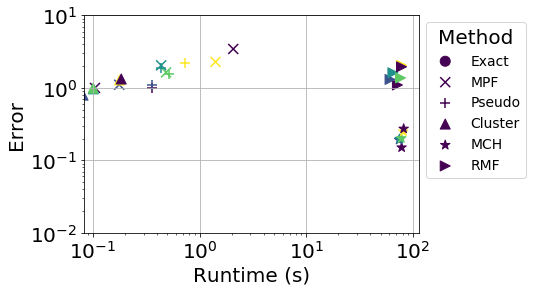

In [14]:
fig,ax = plt.subplots()
markers = 'ox+^*>'
cc = [c for c in colorcycle(len(nrange))]

for m,run,err in zip(markers,runtime,error):
    if m in 'x+':
        lws = 4
    else:
        lws = None
    ax.scatter(run.mean(1),err.mean(1),s=100,c=cc,marker=m,linewidths=lws)
ax.set(xlabel='Runtime (s)',ylabel='Error',xscale='log',yscale='log',
       ylim=[1e-2,10])
ax.legend(('Exact','MPF','Pseudo','Cluster','MCH','RMF'),title='Method',fontsize='x-small',
          bbox_to_anchor=[1.34,1])
ax.grid()

In [87]:
fig.savefig('/Users/eddie/Downloads/runtime.pdf',bbox_inches='tight')

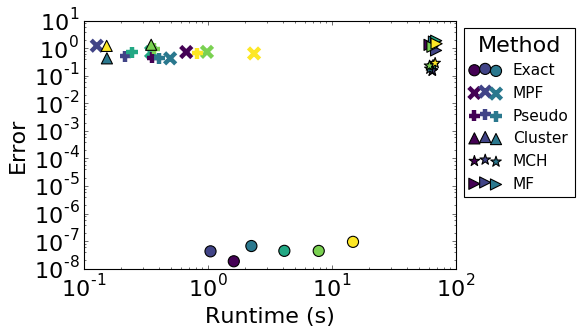

In [58]:
fig,ax = plt.subplots()
markers = 'ox+^*>'
cc = [c for c in colorcycle(runtime.shape[1])]

for m,rowr,rowe in zip(markers,runtime,error):
    if m in 'x+':
        lws = 4
    else:
        lws = None
    ax.scatter(rowr,rowe,s=100,c=cc,marker=m,linewidths=lws)
ax.set(xlabel='Runtime (s)',ylabel='Error',xscale='log',yscale='log',ylim=[1e-8,10])
ax.legend(('Exact','MPF','Pseudo','Cluster','MCH','RMF'),title='Method',fontsize='x-small',
          bbox_to_anchor=[1.34,1])